In [35]:
cd("C:\\Users\\alexm\\Downloads")

In [3]:
import Pkg
Pkg.activate(".")

  Activating project at `C:\Users\alexm`


In [177]:
Pkg.add(["CSV","DataFrames","DSP","Statistics","FFTW","Plots"])

   Resolving package versions...
  No Changes to `C:\Users\alexm\Project.toml`
  No Changes to `C:\Users\alexm\Manifest.toml`


In [178]:
using CSV, DataFrames, DSP, Statistics, FFTW, Plots

In [65]:
df = CSV.read("Sample_C_Test3.csv", DataFrame)  
times_sec = df[!, "Timestamps (sec)"]
ch1_signal = df[!, "CH 1 Analog Input (mV)"]
ch2_signal = df[!, "CH 2 Analog Input (mV)"]

3980-element Vector{Float64}:
 -1.838684082
 -1.766967773
 -1.728820801
 -1.840209961
 -1.753234863
 -1.831054688
 -1.823425293
 -1.800537109
 -1.85546875
 -1.840209961
 -1.710510254
 -1.67388916
 -1.805114746
  ⋮
 -1.721191406
 -1.710510254
 -1.713562012
 -1.698303223
 -1.67388916
 -1.606750488
 -1.605224609
 -1.638793945
 -1.712036133
 -1.631164551
 -1.574707031
 -1.588439941

In [93]:
fs = 250
window_size = 96  
kernel = ones(window_size) / window_size
ch1_filtered = conv(ch1_signal, kernel)  
ch2_filtered = conv(ch2_signal, kernel)  

ch1_filtered = ch1_filtered[1:length(ch1_signal)]
ch2_filtered = ch2_filtered[1:length(ch2_signal)]

3980-element Vector{Float64}:
 -0.019152959187499707
 -0.0375588734895832
 -0.05556742349999977
 -0.07473627726041654
 -0.09299914041666668
 -0.11207262675000007
 -0.13106664021874992
 -0.1498222351041667
 -0.16915003458333322
 -0.18831888834375
 -0.20613670348958302
 -0.22357304890624996
 -0.2423763275104167
  ⋮
 -1.826763153083333
 -1.8305301666354166
 -1.8332640330104168
 -1.8332481384375
 -1.83078447978125
 -1.8253644307499997
 -1.8213748931875
 -1.8177668253541666
 -1.8144448598229168
 -1.8105824788437497
 -1.80616378784375
 -1.8013477325416667

In [154]:
function detect_r_peaks(signal)
    peaks = [i for i in 2:length(signal)-1 if signal[i] > signal[i-1] && signal[i] > signal[i+1]]
    return peaks
end

r_peaks_ch1 = detect_r_peaks(ch1_filtered)
r_peaks_ch2 = detect_r_peaks(ch2_filtered)

534-element Vector{Int64}:
  107
  112
  115
  117
  120
  123
  136
  146
  157
  161
  163
  209
  214
    ⋮
 3890
 3893
 3898
 3902
 3907
 3909
 3913
 3922
 3924
 3930
 3941
 3957

In [156]:
rr_intervals_ch1 = diff(times_sec[r_peaks_ch1])
rr_intervals_ch2 = diff(times_sec[r_peaks_ch2])

533-element Vector{Float64}:
 0.009999999999990905
 0.0060000000000854925
 0.004000000000019099
 0.005999999999971806
 0.005999999999971806
 0.025999999999953616
 0.020000000000095497
 0.021999999999934516
 0.008000000000038199
 0.004000000000019099
 0.09199999999998454
 0.009999999999990905
 0.014000000000010004
 ⋮
 0.02800000000002001
 0.005999999999971806
 0.009999999999990905
 0.008000000000038199
 0.009999999999990905
 0.004000000000019099
 0.008000000000038199
 0.017999999999915417
 0.004000000000019099
 0.012000000000057298
 0.021999999999934516
 0.03200000000003911

In [152]:
function compute_time_metrics(rr_intervals)
    sdnn = std(rr_intervals)
    rmssd = sqrt(mean(diff(rr_intervals).^2))
    return sdnn, rmssd
end

sdnn_ch1, rmssd_ch1 = compute_time_metrics(rr_intervals_ch1)
println("CH1 - SDNN: $sdnn_ch1, RMSSD: $rmssd_ch1")

sdnn_ch2, rmssd_ch2 = compute_time_metrics(rr_intervals_ch2)
println("CH2 - SDNN: $sdnn_ch2, RMSSD: $rmssd_ch2")

CH1 - SDNN: 0.018850893607635952, RMSSD: 0.02578690756507961
CH2 - SDNN: 0.020378824244587382, RMSSD: 0.027551319169330558


In [168]:
function compute_frequency_metrics(rr_intervals)
    fft_result = fft(rr_intervals .- mean(rr_intervals))
    psd = abs.(fft_result[1:div(length(rr_intervals), 2)]).^2 / length(rr_intervals)
    fs_rr = 1 / mean(rr_intervals)  
    freqs = (0:div(length(rr_intervals), 2)-1) * (fs_rr / length(rr_intervals))
    ulf_power = sum(psd[freqs .<= 0.04])
    lf_power = sum(psd[(freqs .> 0.15) .& (freqs .<= 0.4)])
    hf_power = sum(psd[(freqs .> 0.4) .& (freqs .<= 1.5)])
    lf_hf_ratio = lf_power / hf_power
    return ulf_power, lf_power, hf_power, lf_hf_ratio, freqs, psd
end

ulf_ch1, lf_ch1, hf_ch1, lf_hf_ratio_ch1, freqs_ch1, psd_ch1 = compute_frequency_metrics(rr_intervals_ch1)
println("CH1 - ULF: $ulf_ch1, LF: $lf_ch1, HF: $hf_ch1, LF/HF Ratio: $lf_hf_ratio_ch1")

ulf_ch2, lf_ch2, hf_ch2, lf_hf_ratio_ch2, freqs_ch2, psd_ch2 = compute_frequency_metrics(rr_intervals_ch2)
println("CH2 - ULF: $ulf_ch2, LF: $lf_ch2, HF: $hf_ch2, LF/HF Ratio: $lf_hf_ratio_ch2")

CH1 - ULF: 8.996176075769075e-34, LF: 2.1639322887625153e-5, HF: 0.00584957912924178, LF/HF Ratio: 0.003699295694531451
CH2 - ULF: 5.7814032101680626e-36, LF: 0.0003690508062363488, HF: 0.008337916294921923, LF/HF Ratio: 0.04426175475773406


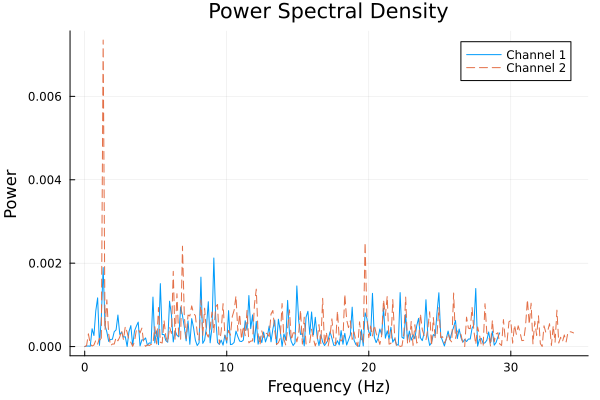

In [198]:
plot(freqs_ch1, psd_ch1, label="Channel 1", xlabel="Frequency (Hz)", ylabel="Power", title="Power Spectral Density")
plot!(freqs_ch2, psd_ch2, label="Channel 2", xlabel="Frequency (Hz)", ylabel="Power", title="Power Spectral Density", linestyle=:dash)